### Math 168 Final Project

In [8]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import scipy as sp

#### Facebook Dataset Inspection + Bottleneck Detection + Shortest Distance Distribution

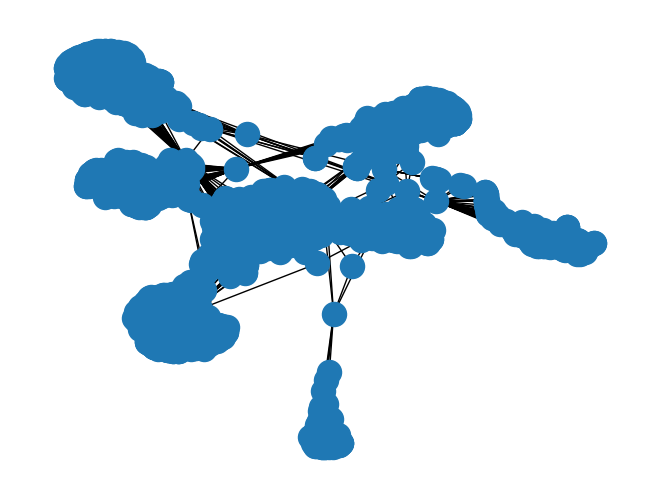

In [5]:
df = pd.read_csv('facebook.txt', delimiter=' ')
edges_list = [(df.iloc[i, 0], df.iloc[i, 1]) for i in range(len(df))]
edges_list.append((0, 1))

G = nx.Graph()
G.add_edges_from(edges_list)

ego_nodes = [1684, 1912, 3437, 3980, 0, 107, 348, 414, 686, 968]
nx.draw(G)


In [ ]:
closeness_centrality_scores = nx.closeness_centrality(G)
betweenness_centrality_scores = nx.betweenness_centrality(G)
degree_centrality_scores = nx.degree_centrality(G)
evect_centrality_scores = nx.eigenvector_centrality(G)

In [41]:
nodes = [n for n in range(4039)]

centrality_df = pd.DataFrame.from_dict({"Node": nodes, "Closeness Centrality Score": list(closeness_centrality_scores.values()), "Betweenness Centrality Score": list(betweenness_centrality_scores.values()),
                                       "Degree Centrality Score": list(degree_centrality_scores.values()), "Evector Centrality Scores": list(evect_centrality_scores.values())})

centrality_df.to_csv('facebook_centrality.csv')


In [9]:
# bottleneck = node with betweenness centrality in top 10 percentile
centrality_df = pd.read_csv('facebook_centrality.csv')
cutoff = np.percentile(centrality_df.loc[:, "Betweenness Centrality Score"], 90)
bottlenecks = []

for i in range(4039):
    if centrality_df.loc[i, "Betweenness Centrality Score"] >= cutoff:
        bottlenecks.append(i)

print(f"The proportion of bottleneck nodes to all nodes is {len(bottlenecks)/4039}")

The proportion of bottleneck nodes to all nodes is 0.10002475860361476


In [12]:
shortest_paths_lengths = dict(nx.shortest_path_length(G))
shortest_path_lengths_matrix = np.zeros((4039, 4039))

for i in range(4039):
    for j in range(4039):
        shortest_path_lengths_matrix[i, j] = shortest_paths_lengths[i][j]

short_path_lengths_df = pd.DataFrame(shortest_path_lengths_matrix)
short_path_lengths_df.to_csv('facebook_path_lengths.csv')

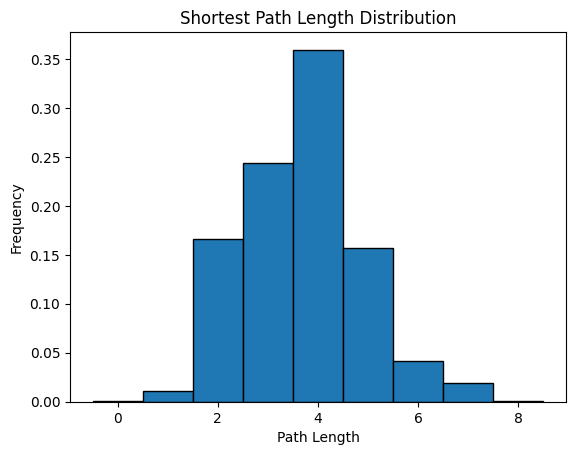

In [11]:
path_lengths = []
short_path_lengths_df = pd.read_csv('facebook_path_lengths.csv')

for i in range(4039):
    for j in range(i+1, 4039):
        path_lengths.append(short_path_lengths_df.iloc[i, j])

plt.hist(path_lengths, bins=range(int(max(path_lengths))+2), align='left', edgecolor = "Black", density=True)
plt.xlabel("Path Length")
plt.ylabel("Frequency")
plt.title("Shortest Path Length Distribution")
plt.savefig('facebook_shortest_path_lengths.png')
plt.show()

#### Graph Processing

I've used gplus_combined.txt.gz and facebook_combined.txt.gz files from the websites.

https://snap.stanford.edu/data/egonets-Facebook.html


https://snap.stanford.edu/data/ego-Gplus.html

In [8]:
# Graph Processing for G+ and Facebook

def load_ego_network(ego_id, base_path, directed=False):
    edge_file = os.path.join(base_path, f"{ego_id}.edges")

    # Create graph (directed for G+, undirected for Facebook)
    G = nx.DiGraph() if directed else nx.Graph()

    with open(edge_file, 'r') as f:
        for line in f:
            node1, node2 = map(int, line.strip().split())
            G.add_edge(node1, node2)
            # if not directed:
            #     G.add_edge(node2, node1)  # Ensure undirected edges are bidirectional
    return G

facebook_base_path = "/Users/anirudhkrishna/Desktop/Math 168/Project/facebook"  # Add your own - I've put this temporarily.
gplus_base_path = "/Users/anirudhkrishna/Desktop/Math 168/Project/gplus"  

facebook_ego_id = "0"  
gplus_ego_id = "100466178325794757407" 
# gplus_ego_id = "113455290791279442483" -- Ignore

G_fb = load_ego_network(facebook_ego_id, facebook_base_path, directed=False)
G_gplus = load_ego_network(gplus_ego_id, gplus_base_path, directed=True)

print(f"Facebook Ego Network ({facebook_ego_id}): {len(G_fb.nodes)} nodes, {len(G_fb.edges)} edges")
print(f"Google+ Ego Network ({gplus_ego_id}): {len(G_gplus.nodes)} nodes, {len(G_gplus.edges)} edges")

Facebook Ego Network (0): 333 nodes, 2519 edges
Google+ Ego Network (100466178325794757407): 344 nodes, 4178 edges


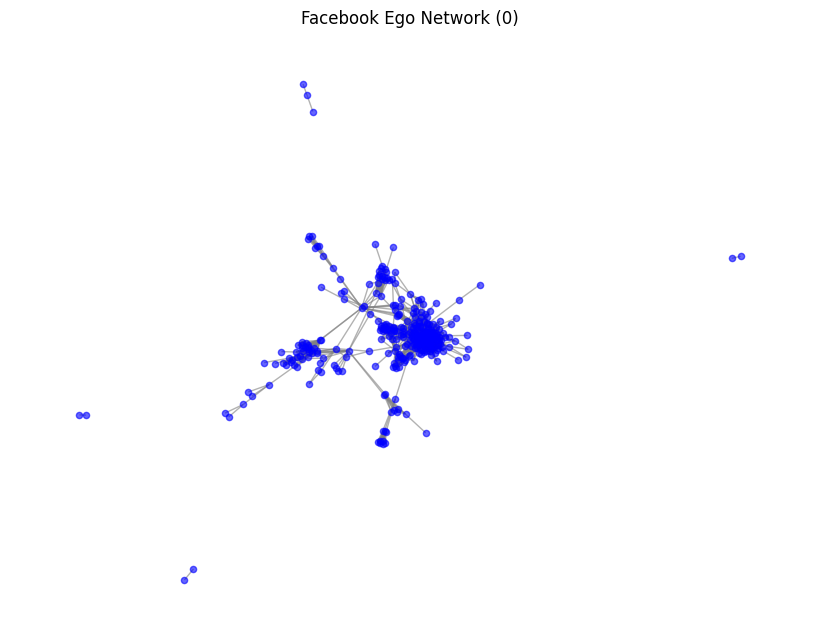

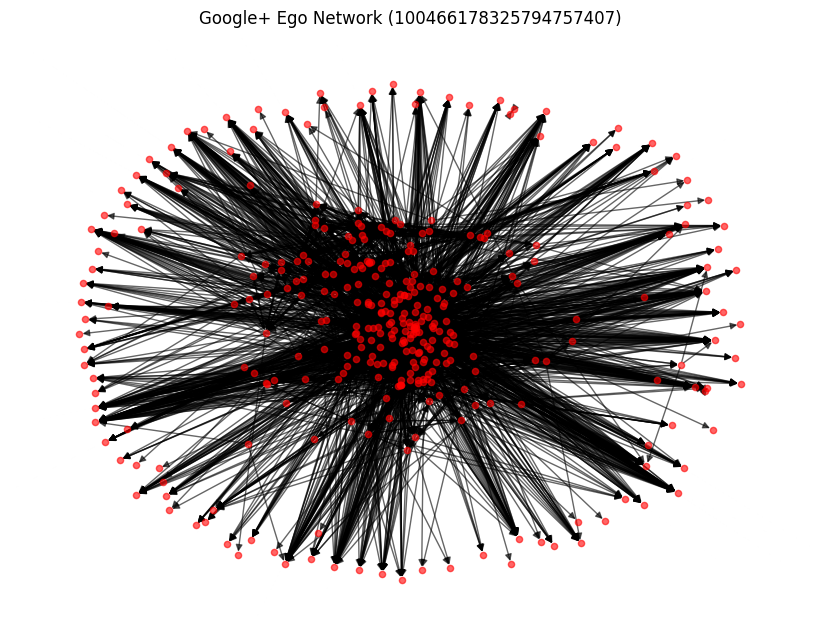

In [9]:
def visualize_network(G, title, node_color='blue', edge_color='gray', figsize=(8, 6)):
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, seed=42)  
    nx.draw(G, pos, with_labels=False, node_size=20, node_color=node_color, edge_color=edge_color, alpha=0.6)
    plt.title(title)
    plt.show()


visualize_network(G_fb, f"Facebook Ego Network ({facebook_ego_id})", node_color='blue', edge_color='gray')
visualize_network(G_gplus, f"Google+ Ego Network ({gplus_ego_id})", node_color='red', edge_color='black')

#### Computing Katz Centrality (since it's good with both directed and undirected graphs)

In [13]:
def compute_katz_top_spreaders(G, top_n=10):
    """Computes Katz centrality and returns the top spreaders."""
    katz_centrality = nx.katz_centrality_numpy(G, alpha=0.1, beta=1.0)
    top_spreaders = sorted(katz_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_spreaders

top_spreaders_fb = compute_katz_top_spreaders(G_fb, top_n=10)
top_spreaders_gplus = compute_katz_top_spreaders(G_gplus, top_n=10)

df_fb_katz = pd.DataFrame(top_spreaders_fb, columns=["Node", "Katz Centrality Score"])
df_gplus_katz = pd.DataFrame(top_spreaders_gplus, columns=["Node", "Katz Centrality Score"])

print("\nTop Spreaders in Facebook (Katz Centrality):")
print(df_fb_katz)
print("\nTop Spreaders in Google+ (Katz Centrality):")
print(df_gplus_katz)


Top Spreaders in Facebook (Katz Centrality):
   Node  Katz Centrality Score
0     7               0.263953
1   339               0.261070
2    87               0.193444
3   213               0.185224
4   291               0.169499
5   246               0.167429
6   136               0.166437
7   315               0.156071
8   168               0.154428
9    22               0.146057

Top Spreaders in Google+ (Katz Centrality):
                    Node  Katz Centrality Score
0  116274984352579031823               0.209695
1  101477619738648074996               0.204064
2  107197977601900902096               0.203275
3  104597453028172833211               0.188066
4  109870053628419941069               0.186548
5  102389125283549686273               0.177200
6  115061395390469360477               0.175977
7  111231223957836734952               0.175844
8  114142060222176373436               0.163871
9  117072717171084573790               0.162738


#### SIR Modeling

In [17]:
# Custom function for directed SIR. Unfortunately libraries were not working for directed SIR so we had to write our own stuff.

def directed_SIR(G, beta=0.1, gamma=0.05, initial_spreader=None, tmax=10):
    """
    Runs an SIR model on a directed graph (Google+).
    - G: Directed NetworkX graph
    - beta: Infection probability
    - gamma: Recovery probability
    - initial_spreader: Node ID to start spread
    - tmax: Max simulation steps
    """
    if initial_spreader is None:
        katz_centrality = nx.katz_centrality_numpy(G, alpha=0.1, beta=1.0)
        potential_spreaders = [node for node in G.nodes if G.out_degree(node) > 0]
        if not potential_spreaders:
            print("No valid initial spreaders with outgoing edges. Exiting SIR.")
            return
        initial_spreader = max(potential_spreaders, key=lambda x: katz_centrality.get(x, 0))

    states = {node: "S" for node in G.nodes}
    states[initial_spreader] = "I"
    infected = {initial_spreader}
    recovered = set()

    time_series = {"S": [len(G.nodes)], "I": [1], "R": [0]}

    for t in range(tmax):
        new_infected = set()
        new_recovered = set()

        for node in infected:
            for neighbor in G.successors(node):  # Only spread in outgoing direction
                if states[neighbor] == "S" and random.random() < beta:
                    states[neighbor] = "I"
                    new_infected.add(neighbor)

            if random.random() < gamma:
                states[node] = "R"
                new_recovered.add(node)

        infected = (infected - new_recovered) | new_infected
        recovered |= new_recovered

        time_series["S"].append(len(G.nodes) - len(infected) - len(recovered))
        time_series["I"].append(len(infected))
        time_series["R"].append(len(recovered))

        if not infected:
            break

    plt.figure(figsize=(8, 5))
    plt.plot(range(len(time_series["S"])), time_series["S"], label="Susceptible", color='blue')
    plt.plot(range(len(time_series["I"])), time_series["I"], label="Infected (Spreading Info)", color='red')
    plt.plot(range(len(time_series["R"])), time_series["R"], label="Recovered (Lost Interest)", color='green')
    plt.xlabel("Time Steps")
    plt.ylabel("Number of Users")
    plt.title(f"SIR Diffusion Model on {len(G.nodes)}-Node Google+ Network")
    plt.legend()
    plt.show()

In [18]:
# Custom function for undirected SIR
def undirected_SIR(G, beta=0.1, gamma=0.05, initial_spreader=None, tmax=10):
    """
    Runs an SIR model on an undirected graph (Facebook).
    - G: Undirected NetworkX graph
    - beta: Infection probability
    - gamma: Recovery probability
    - initial_spreader: Node ID to start spread
    - tmax: Max simulation steps
    """
    if initial_spreader is None:
        katz_centrality = nx.katz_centrality_numpy(G, alpha=0.1, beta=1.0)
        initial_spreader = max(katz_centrality, key=katz_centrality.get)

    states = {node: "S" for node in G.nodes}
    states[initial_spreader] = "I"
    infected = {initial_spreader}
    recovered = set()

    time_series = {"S": [len(G.nodes)], "I": [1], "R": [0]}

    for t in range(tmax):
        new_infected = set()
        new_recovered = set()

        for node in infected:
            for neighbor in G.neighbors(node):
                if states[neighbor] == "S" and random.random() < beta:
                    states[neighbor] = "I"
                    new_infected.add(neighbor)

            if random.random() < gamma:
                states[node] = "R"
                new_recovered.add(node)

        infected = (infected - new_recovered) | new_infected
        recovered |= new_recovered

        time_series["S"].append(len(G.nodes) - len(infected) - len(recovered))
        time_series["I"].append(len(infected))
        time_series["R"].append(len(recovered))

        if not infected:
            break

    plt.figure(figsize=(8, 5))
    plt.plot(range(len(time_series["S"])), time_series["S"], label="Susceptible", color='blue')
    plt.plot(range(len(time_series["I"])), time_series["I"], label="Infected (Spreading Info)", color='red')
    plt.plot(range(len(time_series["R"])), time_series["R"], label="Recovered (Lost Interest)", color='green')
    plt.xlabel("Time Steps")
    plt.ylabel("Number of Users")
    plt.title(f"SIR Diffusion Model on {len(G.nodes)}-Node Facebook Network")
    plt.legend()
    plt.show()

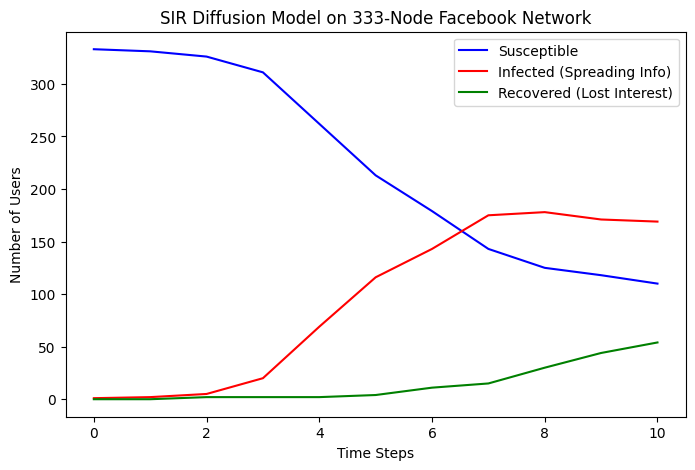

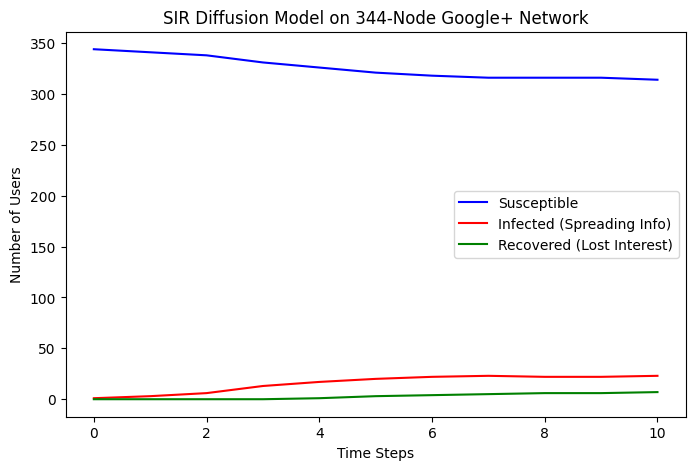

In [19]:
undirected_SIR(G_fb)  # Facebook!!
directed_SIR(G_gplus)  # Google+!!

In [ ]:
# THIS CODE IS NOT BEING USED CURRENTLY. It essentially picks subgraphs of equal size from G+ & Facebook. But I chose to pick from the Ego-Networks already given by the dataset.

def load_graph(file_path):
    return nx.read_edgelist(file_path, nodetype=int)

def sample_subgraph(G, target_size):
    if len(G.nodes) <= target_size:
        return G.copy()

    # Start from a random high-degree node (to maintain structure)
    start_node = max(G.degree, key=lambda x: x[1])[0]

    # Perform BFS expansion until we reach the required size
    sampled_nodes = set([start_node])
    queue = [start_node]

    while len(sampled_nodes) < target_size and queue:
        node = queue.pop(0)
        neighbors = list(G.neighbors(node))
        random.shuffle(neighbors)  # Shuffle to avoid order bias

        for neighbor in neighbors:
            if neighbor not in sampled_nodes:
                sampled_nodes.add(neighbor)
                queue.append(neighbor)
            if len(sampled_nodes) >= target_size:
                break

    return G.subgraph(sampled_nodes).copy()

facebook_path = "facebook_combined.txt"
gplus_path = "gplus_combined.txt"

G_fb = load_graph(facebook_path)
G_gplus = load_graph(gplus_path)

# Determine target size (smallest network)
target_size = min(len(G_fb.nodes), len(G_gplus.nodes))

# Sample equally sized subgraphs
G_fb_sampled = sample_subgraph(G_fb, target_size)
G_gplus_sampled = sample_subgraph(G_gplus, target_size)

# Save subgraphs
nx.write_edgelist(G_fb_sampled, "facebook_subgraph.edgelist", data=False)
nx.write_edgelist(G_gplus_sampled, "googleplus_subgraph.edgelist", data=False)

print(f"Sampled Facebook subgraph: {len(G_fb_sampled.nodes)} nodes, {len(G_fb_sampled.edges)} edges")
print(f"Sampled Google+ subgraph: {len(G_gplus_sampled.nodes)} nodes, {len(G_gplus_sampled.edges)} edges")